<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> May 23, 2020 (Saturday) 23:00
</div>

# Exercise 11.1. Generative adversarial networks (GANs). DCGAN: Deep convolutional GAN

The goal of this exercise is to get familiar with generative adversarial networks and specifically DCGAN. The model was proposed by [Radford et al., 2015](https://arxiv.org/pdf/1511.06434.pdf).

DCGAN is probably the simplest GAN model which is relatively easy to train.

In [0]:
skip_training = False  # Set this flag to True before validation and submission

In [0]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [0]:
device = torch.device('cuda:0')
# device = torch.device('cpu')

In [0]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise.

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)

batch_size = 100
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Generative adversarial networks

Our task is to train a generative model of the data, that is a model from which we can draw samples that will have a distribution similar to the distribution of the training data (MNIST digits in our case).

## Generator

The generative model that we are going to train is:
\begin{align}
z &\sim N(0, I)
\\
x &= G(z)
\end{align}
that is the data is generated by applying a nonlinear transformation to samples drawn from the standard normal distribution.

We are going to model $G$ with a deep neural network created below. In DCGAN, the generator is made of only transposed convolutional layers `ConvTranspose2d`.
The proposed architecture for the generator:
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `4*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `tanh`.
   
The **`tanh` nonlinearity guarantees that the output is between 0 and 1** (**NOT TRUE, [-1,1]**) which holds for MNIST digits.

**The exact architecture is not tested in this assignment. If the description is not full, please fill the missing pieces according to your preferences.**

In [0]:
def normal_weight_init(m):
    """
    Method to initialize weights with a zero-centered Normal distribution with a
    standard deviation of 0.02.
    """
    mean = 0.0
    std = 0.02
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        # m.bias.data.zero_() # already specified in class

In [0]:
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """GAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        # YOUR CODE HERE
        super(Generator, self).__init__()
        self.ConvTrans1 = nn.ConvTranspose2d(in_channels=nz, out_channels=4*ngf, kernel_size=4, stride=2, padding=0,  bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(num_features=4*ngf)
        self.ConvTrans2 = nn.ConvTranspose2d(4*ngf, 2*ngf, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(2*ngf)
        self.ConvTrans3 = nn.ConvTranspose2d(2*ngf, ngf, 4, 2, 2, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf)
        self.ConvTrans4 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)

    def weight_init(self):
        """
        Weight initialization for kernel weights.
        """
        for m in self._modules:
            normal_weight_init(self._modules[m])

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
                          so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        # YOUR CODE HERE
        if verbose: print("before :", z.size())
        z = F.relu(self.BatchNorm1(self.ConvTrans1(z)))
        if verbose: print(z.size())
        z = F.relu(self.BatchNorm2(self.ConvTrans2(z)))
        if verbose: print(z.size())
        z = F.relu(self.BatchNorm3(self.ConvTrans3(z)))
        if verbose: print(z.size())
        z = torch.tanh(self.ConvTrans4(z))
        if verbose: print("after :", z.size())

        return z
        

In [10]:
def test_Generator_shapes():
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    batch_size = 32
    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

before : torch.Size([32, 10, 1, 1])
torch.Size([32, 256, 4, 4])
torch.Size([32, 128, 8, 8])
torch.Size([32, 64, 14, 14])
after : torch.Size([32, 1, 28, 28])
Success


### Loss for training the generator

The generative model will be guided by a discriminator whose task is to separate (classify) data into two classes:
* true data (samples from the training set)
* generated data (samples generated by the generator).

In [0]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

The task of the generator is to confuse the discriminator as much as possible, which is the case when the distribution produced by the generator perfectly replicates the data distribution.

In the cell below, you need to implement the **loss function** which is used to **train the generator**. The loss should be the `binary_cross_entropy` loss computed with `real_label` as targets for the generated samples.

In [0]:
def generator_loss(D, fake_images):
    """Loss computed to train the GAN generator.

    Args:
      D: The discriminator whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produced by the generator.

    Returns:
      loss: The sum of the binary cross-entropy losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    criterion = nn.BCELoss()
    batch_size = fake_images.size(0)
    input = D(fake_images)
    # target = torch.Tensor([real_label for _ in range(batch_size)], device=fake_images.device)
    target = torch.full((batch_size, ), real_label, device=fake_images.device, dtype=torch.float)
    loss = criterion(input, target)

    return loss

In [13]:
tests.test_generator_loss(generator_loss)

loss: tensor(1.0730)
expected: tensor(1.0730)
Success


## Discriminator

In DCGAN, the discriminator is a stack of only convolutional layers.

The proposed architecture for the discriminator:
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `2*ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `4*ndf` output channels, no bias,
   followed by LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `sigmoid`.

**The exact architecture is not tested in this assignment. If the description is not full, please fill the missing pieces according to your preferences.**

In [0]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        """GAN discriminator.
        
        Args:
          nc:  Number of channels in images.
          ndf: Base size (number of channels) of the discriminator layers.
        """
        # YOUR CODE HERE
        super(Discriminator, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ndf)
        self.LRelu1 = nn.LeakyReLU(negative_slope=0.2)
        self.Conv2 = nn.Conv2d(ndf, 2*ndf, 4, 2, padding=1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(2*ndf)
        self.LRelu2 = nn.LeakyReLU(0.2)
        self.Conv3 = nn.Conv2d(2*ndf, 4*ndf, 4, 2, padding=1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(4*ndf)
        self.LRelu3 = nn.LeakyReLU(0.2)
        self.Conv4 = nn.Conv2d(4*ndf, nc, 4, 2, padding=1, bias=False)

    def weight_init(self):
        """Weight initialization for kernel weights.
        """
        for m in self._modules:
            normal_weight_init(self._modules[m])

    def forward(self, x, verbose=False):
        """Classify given images into real/fake.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be classified.
        
        Returns:
          out of shape (batch_size,): Probabilities that images are real. All elements should be between 0 and 1.
        """
        # YOUR CODE HERE
        if verbose: print("before :", x.size())
        x = self.LRelu1(self.BatchNorm1(self.Conv1(x)))
        if verbose: print(x.size())
        x = self.LRelu2(self.BatchNorm2(self.Conv2(x)))
        if verbose: print(x.size())
        x = self.LRelu3(self.BatchNorm3(self.Conv3(x)))
        if verbose: print(x.size())
        x = torch.sigmoid(self.Conv4(x)).squeeze()
        if verbose: print("after :", x.size())
        
        return x

In [15]:
def test_Discriminator_shapes():
    batch_size = 32
    netD = Discriminator(nc=1, ndf=64)

    images = torch.ones(32, 1, 28, 28)
    out = netD(images, verbose=True)

    assert out.shape == torch.Size([batch_size]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

before : torch.Size([32, 1, 28, 28])
torch.Size([32, 64, 14, 14])
torch.Size([32, 128, 7, 7])
torch.Size([32, 256, 3, 3])
after : torch.Size([32])
Success


### Loss for training the discriminator

The discriminator is trained to solve a binary classification problem: to separate real data from generated samples. Thus, the output of the discriminator should be a scalar between 0 and 1.

You need to implement the loss function used to train the discriminator. The dicriminator uses the `binary_cross_entropy` loss using `real_label` as targets for real samples and `fake_label` as targets for generated samples.

In [0]:
def discriminator_loss(D, real_images, fake_images):
    """Loss computed to train the GAN discriminator.

    Args:
      D: The discriminator.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images produced by the generator.

    Returns:
      d_loss_real: The mean of the binary cross-entropy losses computed on the real_images.
      D_real: Mean output of the discriminator for real_images. This is useful for tracking convergence.
      d_loss_fake: The mean of the binary cross-entropy losses computed on the fake_images.
      D_fake: Mean output of the discriminator for fake_images. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    bs_real, bs_fake = real_images.size(0), fake_images.size(0)
    input_real = D(real_images)
    input_fake = D(fake_images)

    # target_real = torch.Tensor([real_label for _ in range(bs_real)], device=fake_images.device)
    # target_fake = torch.Tensor([fake_label for _ in range(bs_fake)], device=fake_images.device)
    target_real = torch.full((bs_real,), real_label, device=fake_images.device, dtype=torch.float)
    target_fake = torch.full((bs_fake,), fake_label, device=fake_images.device, dtype=torch.float)

    criterion = nn.BCELoss()
    d_loss_real = criterion(input_real, target_real)
    d_loss_fake = criterion(input_fake, target_fake) 

    D_real = torch.mean(input_real)
    D_fake = torch.mean(input_fake)

    return d_loss_real, D_real, d_loss_fake, D_fake

In [17]:
def test_discriminator_loss():
    netD = Discriminator(nc=1, ndf=64)
    real_images = fake_images = torch.ones(32, 1, 28, 28)

    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_images, fake_images)
    assert d_loss_real.shape == torch.Size([]), "d_loss_real should be a scalar tensor."
    assert 0 < D_real < 1, "D_real should be a scalar between 0 and 1."
    assert d_loss_fake.shape == torch.Size([]), "d_loss_fake should be a scalar tensor."
    assert 0 < D_fake < 1, "D_fake should be a scalar between 0 and 1."
    print('Success')

test_discriminator_loss()

Success


In [18]:
tests.test_discriminator_loss(discriminator_loss)

d_loss_real: tensor(0.3635)
expected d_loss_real: tensor(0.3635)
D_real: tensor(0.7000)
expected D_real: 0.699999988079071
d_loss_fake: 0.22839301824569702
expected d_loss_fake: tensor(0.2284)
D_fake: tensor(0.2000)
expected D_fake: 0.20000000298023224
Success


# Training GANs

We will now train a GAN. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [19]:
from scorer import Scorer
scorer = Scorer()
scorer.to(device)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


Scorer(
  (model): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (relu1): ReLU()
      (drop1): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (relu2): ReLU()
      (drop2): Dropout(p=0.2, inplace=False)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [0]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=64, nc=1)
netD = Discriminator(nc=1, ndf=64)

# Weight initialization
# netG.weight_init()
# netD.weight_init()

netD = netD.to(device)
netG = netG.to(device)

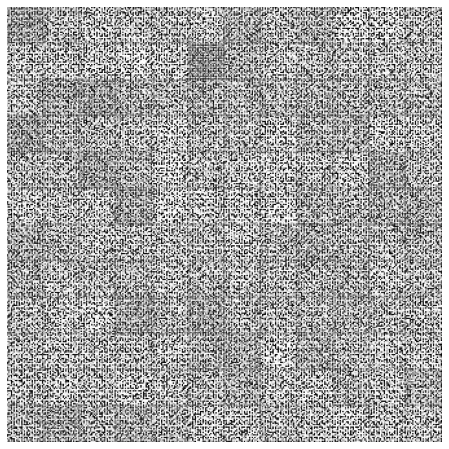

In [21]:
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)

    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the discriminator: Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`
* Optimizer of the generator:     Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`

Hints:
- We will use the scorer defined above to assess the quality of the generated samples. The desired level of .7 should be reached within 15-20 epochs.
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [0, 1].
```
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)
```
- The quality of the generated images should be good (better than with the PixelCNN model).
- You can track `D_real` and `D_fake` returned by function `discriminator_loss()`. When it is hard for the discriminator to separate real and fake images, their values are close to 0.5.

Epoch 0
[0][0][0/600] Loss_D: 1.4214 Loss_G: 1.0786 D(x): 0.4329 D(G(z)): 0.4315
[0][100][100/600] Loss_D: 0.7837 Loss_G: 3.3033 D(x): 0.7873 D(G(z)): 0.3789
[0][200][200/600] Loss_D: 0.5987 Loss_G: 1.8699 D(x): 0.8094 D(G(z)): 0.2958
[0][300][300/600] Loss_D: 0.7478 Loss_G: 0.6423 D(x): 0.5676 D(G(z)): 0.1267
[0][400][400/600] Loss_D: 0.6081 Loss_G: 1.5113 D(x): 0.7669 D(G(z)): 0.2682
[0][500][500/600] Loss_D: 0.7265 Loss_G: 2.2325 D(x): 0.8128 D(G(z)): 0.3841


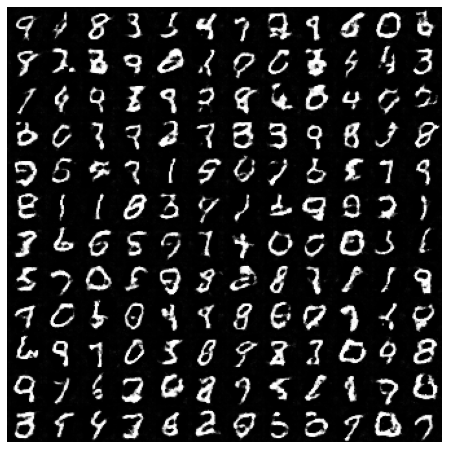

Epoch 1
[1][600][0/600] Loss_D: 1.4681 Loss_G: 2.6674 D(x): 0.9489 D(G(z)): 0.7158
[1][700][100/600] Loss_D: 0.9767 Loss_G: 0.6060 D(x): 0.4521 D(G(z)): 0.1014
[1][800][200/600] Loss_D: 0.7954 Loss_G: 2.0977 D(x): 0.8116 D(G(z)): 0.4168
[1][900][300/600] Loss_D: 0.7355 Loss_G: 0.8655 D(x): 0.6531 D(G(z)): 0.2263
[1][1000][400/600] Loss_D: 0.6599 Loss_G: 1.2924 D(x): 0.6711 D(G(z)): 0.1946
[1][1100][500/600] Loss_D: 0.7990 Loss_G: 1.1746 D(x): 0.5480 D(G(z)): 0.1176


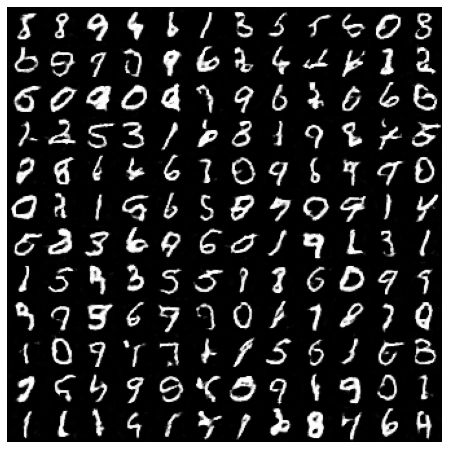

Epoch 2
[2][1200][0/600] Loss_D: 0.7553 Loss_G: 1.6525 D(x): 0.6164 D(G(z)): 0.1997
[2][1300][100/600] Loss_D: 0.7585 Loss_G: 1.0067 D(x): 0.6202 D(G(z)): 0.1988
[2][1400][200/600] Loss_D: 0.8311 Loss_G: 2.3008 D(x): 0.7907 D(G(z)): 0.4039
[2][1500][300/600] Loss_D: 1.0842 Loss_G: 0.2282 D(x): 0.4153 D(G(z)): 0.0971
[2][1600][400/600] Loss_D: 0.8688 Loss_G: 1.0048 D(x): 0.4988 D(G(z)): 0.0809
[2][1700][500/600] Loss_D: 0.7204 Loss_G: 1.6355 D(x): 0.6473 D(G(z)): 0.1984


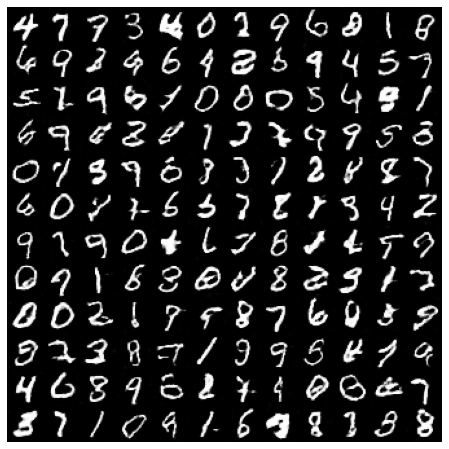

Epoch 3
[3][1800][0/600] Loss_D: 0.7264 Loss_G: 1.9938 D(x): 0.7766 D(G(z)): 0.3447
[3][1900][100/600] Loss_D: 0.9648 Loss_G: 1.9849 D(x): 0.8188 D(G(z)): 0.4847
[3][2000][200/600] Loss_D: 0.7468 Loss_G: 1.6783 D(x): 0.6808 D(G(z)): 0.2526
[3][2100][300/600] Loss_D: 0.7259 Loss_G: 1.0319 D(x): 0.7332 D(G(z)): 0.2938
[3][2200][400/600] Loss_D: 0.7107 Loss_G: 1.8498 D(x): 0.8277 D(G(z)): 0.3762
[3][2300][500/600] Loss_D: 0.7090 Loss_G: 1.7817 D(x): 0.7648 D(G(z)): 0.3276


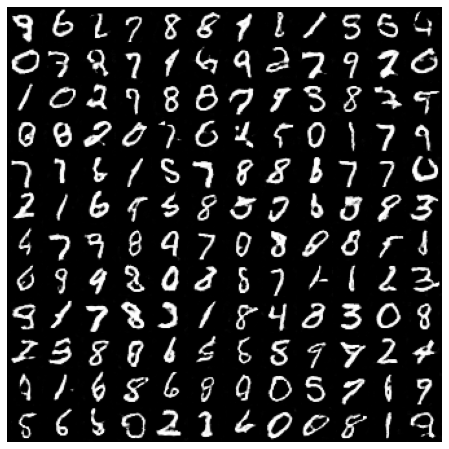

Epoch 4
[4][2400][0/600] Loss_D: 0.6308 Loss_G: 1.9736 D(x): 0.7447 D(G(z)): 0.2465
[4][2500][100/600] Loss_D: 0.9568 Loss_G: 0.6717 D(x): 0.4859 D(G(z)): 0.1455
[4][2600][200/600] Loss_D: 0.9167 Loss_G: 2.4133 D(x): 0.8735 D(G(z)): 0.5004
[4][2700][300/600] Loss_D: 1.3552 Loss_G: 0.9844 D(x): 0.3395 D(G(z)): 0.1181
[4][2800][400/600] Loss_D: 0.8764 Loss_G: 2.1415 D(x): 0.7996 D(G(z)): 0.4447
[4][2900][500/600] Loss_D: 0.6303 Loss_G: 1.8046 D(x): 0.7450 D(G(z)): 0.2509


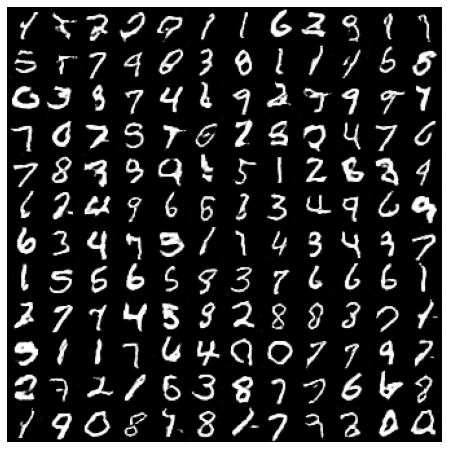

Epoch 5
[5][3000][0/600] Loss_D: 0.7414 Loss_G: 0.8811 D(x): 0.6339 D(G(z)): 0.1889
[5][3100][100/600] Loss_D: 1.0895 Loss_G: 0.7152 D(x): 0.4033 D(G(z)): 0.0779
[5][3200][200/600] Loss_D: 0.7324 Loss_G: 2.4464 D(x): 0.8787 D(G(z)): 0.4090
[5][3300][300/600] Loss_D: 0.7935 Loss_G: 1.4568 D(x): 0.6986 D(G(z)): 0.3073
[5][3400][400/600] Loss_D: 0.7644 Loss_G: 0.8695 D(x): 0.5559 D(G(z)): 0.0869
[5][3500][500/600] Loss_D: 0.9345 Loss_G: 2.9237 D(x): 0.8367 D(G(z)): 0.4773


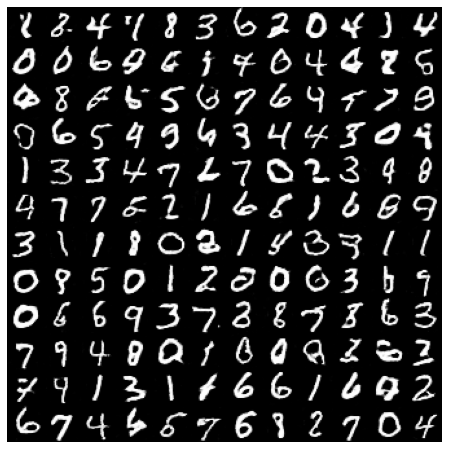

Epoch 6
[6][3600][0/600] Loss_D: 0.6963 Loss_G: 2.4922 D(x): 0.7562 D(G(z)): 0.2967
[6][3700][100/600] Loss_D: 0.5886 Loss_G: 1.4589 D(x): 0.7173 D(G(z)): 0.1944
[6][3800][200/600] Loss_D: 0.5924 Loss_G: 2.3959 D(x): 0.8646 D(G(z)): 0.3243
[6][3900][300/600] Loss_D: 0.7561 Loss_G: 1.6296 D(x): 0.6018 D(G(z)): 0.1527
[6][4000][400/600] Loss_D: 0.8240 Loss_G: 2.0632 D(x): 0.8385 D(G(z)): 0.4415
[6][4100][500/600] Loss_D: 0.7144 Loss_G: 2.3646 D(x): 0.7707 D(G(z)): 0.3140


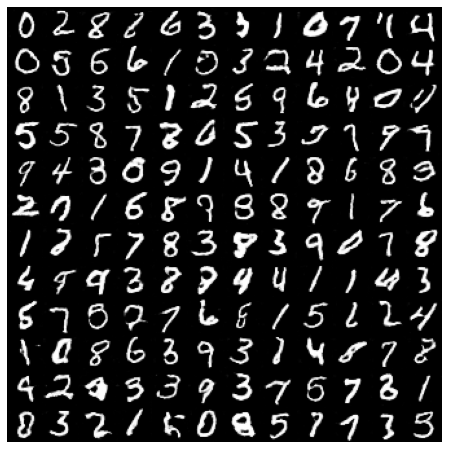

Epoch 7
[7][4200][0/600] Loss_D: 0.7415 Loss_G: 1.7227 D(x): 0.6485 D(G(z)): 0.2151
[7][4300][100/600] Loss_D: 0.9017 Loss_G: 0.6977 D(x): 0.5246 D(G(z)): 0.1156
[7][4400][200/600] Loss_D: 0.6985 Loss_G: 1.9968 D(x): 0.6866 D(G(z)): 0.2308
[7][4500][300/600] Loss_D: 0.8448 Loss_G: 2.2680 D(x): 0.8954 D(G(z)): 0.4702
[7][4600][400/600] Loss_D: 0.7958 Loss_G: 0.5684 D(x): 0.5963 D(G(z)): 0.1725
[7][4700][500/600] Loss_D: 0.6185 Loss_G: 1.4782 D(x): 0.6918 D(G(z)): 0.1717


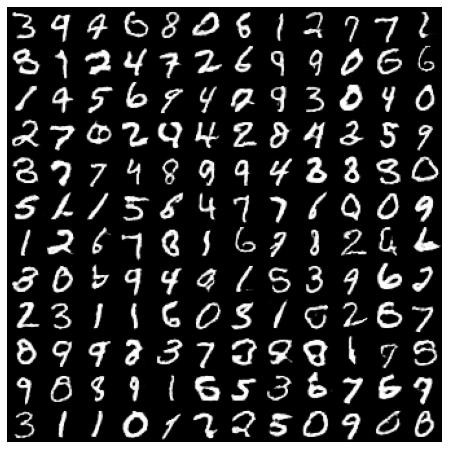

Epoch 8
[8][4800][0/600] Loss_D: 0.7053 Loss_G: 1.1702 D(x): 0.6728 D(G(z)): 0.2091
[8][4900][100/600] Loss_D: 0.6424 Loss_G: 2.3011 D(x): 0.8017 D(G(z)): 0.3066
[8][5000][200/600] Loss_D: 0.6499 Loss_G: 2.7197 D(x): 0.8964 D(G(z)): 0.3805
[8][5100][300/600] Loss_D: 0.7332 Loss_G: 1.1769 D(x): 0.6849 D(G(z)): 0.2510
[8][5200][400/600] Loss_D: 0.5750 Loss_G: 1.8209 D(x): 0.7247 D(G(z)): 0.1840
[8][5300][500/600] Loss_D: 0.8482 Loss_G: 1.3460 D(x): 0.5942 D(G(z)): 0.2061


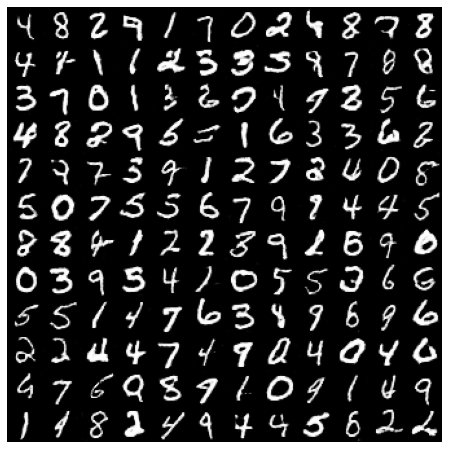

Epoch 9
[9][5400][0/600] Loss_D: 0.9325 Loss_G: 0.6752 D(x): 0.4883 D(G(z)): 0.0992
[9][5500][100/600] Loss_D: 0.6653 Loss_G: 2.1397 D(x): 0.6518 D(G(z)): 0.1606
[9][5600][200/600] Loss_D: 1.3617 Loss_G: 0.4648 D(x): 0.3550 D(G(z)): 0.0620
[9][5700][300/600] Loss_D: 0.5130 Loss_G: 1.6930 D(x): 0.7119 D(G(z)): 0.1195
[9][5800][400/600] Loss_D: 0.6944 Loss_G: 2.7530 D(x): 0.9397 D(G(z)): 0.4288
[9][5900][500/600] Loss_D: 0.6787 Loss_G: 1.4410 D(x): 0.8687 D(G(z)): 0.3677


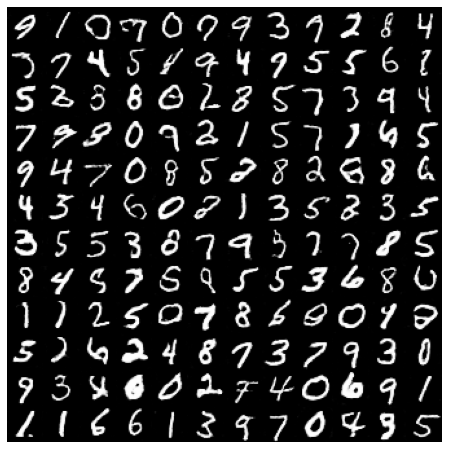

Epoch 10
[10][6000][0/600] Loss_D: 0.5441 Loss_G: 2.4994 D(x): 0.7573 D(G(z)): 0.1955
[10][6100][100/600] Loss_D: 0.5917 Loss_G: 2.0878 D(x): 0.7148 D(G(z)): 0.1770
[10][6200][200/600] Loss_D: 1.0043 Loss_G: 2.2793 D(x): 0.8066 D(G(z)): 0.4832
[10][6300][300/600] Loss_D: 0.5281 Loss_G: 1.4480 D(x): 0.7892 D(G(z)): 0.2161
[10][6400][400/600] Loss_D: 0.6557 Loss_G: 2.2853 D(x): 0.8278 D(G(z)): 0.3354
[10][6500][500/600] Loss_D: 0.5327 Loss_G: 1.6744 D(x): 0.7727 D(G(z)): 0.2078


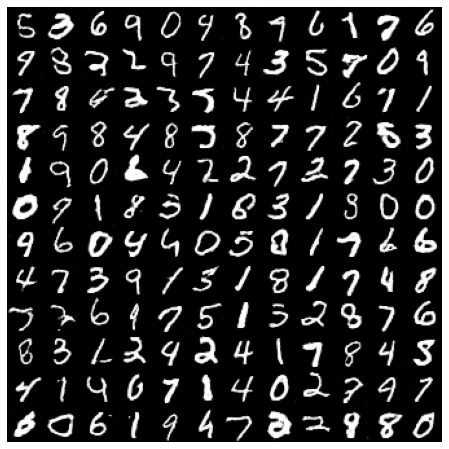

Epoch 11
[11][6600][0/600] Loss_D: 0.7084 Loss_G: 2.5550 D(x): 0.8902 D(G(z)): 0.4077
[11][6700][100/600] Loss_D: 0.7740 Loss_G: 1.7828 D(x): 0.6915 D(G(z)): 0.2766
[11][6800][200/600] Loss_D: 0.6755 Loss_G: 2.4128 D(x): 0.6575 D(G(z)): 0.1527
[11][6900][300/600] Loss_D: 0.4696 Loss_G: 1.8818 D(x): 0.8220 D(G(z)): 0.2097
[11][7000][400/600] Loss_D: 0.5494 Loss_G: 1.4137 D(x): 0.6982 D(G(z)): 0.1296
[11][7100][500/600] Loss_D: 0.6442 Loss_G: 0.7347 D(x): 0.6182 D(G(z)): 0.0747


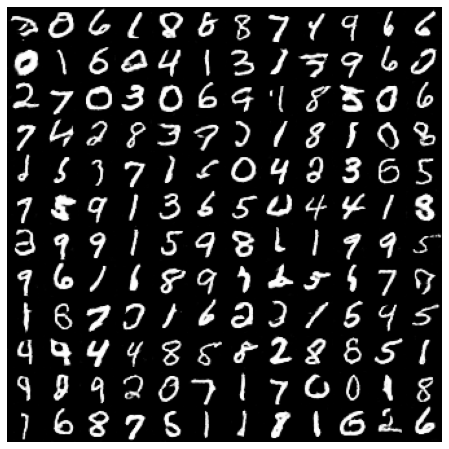

Epoch 12
[12][7200][0/600] Loss_D: 0.7325 Loss_G: 1.3152 D(x): 0.7523 D(G(z)): 0.3002
[12][7300][100/600] Loss_D: 0.8040 Loss_G: 0.9820 D(x): 0.6008 D(G(z)): 0.1840
[12][7400][200/600] Loss_D: 0.4708 Loss_G: 2.4458 D(x): 0.7523 D(G(z)): 0.1342
[12][7500][300/600] Loss_D: 0.5164 Loss_G: 1.5873 D(x): 0.7682 D(G(z)): 0.1865
[12][7600][400/600] Loss_D: 0.7222 Loss_G: 1.5127 D(x): 0.6514 D(G(z)): 0.1806
[12][7700][500/600] Loss_D: 0.9239 Loss_G: 3.3746 D(x): 0.9273 D(G(z)): 0.5012


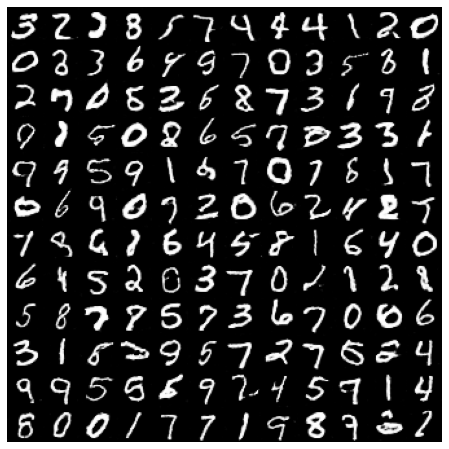

Epoch 13
[13][7800][0/600] Loss_D: 0.5160 Loss_G: 1.5430 D(x): 0.7229 D(G(z)): 0.1304
[13][7900][100/600] Loss_D: 0.6228 Loss_G: 2.0833 D(x): 0.8316 D(G(z)): 0.3127
[13][8000][200/600] Loss_D: 0.7729 Loss_G: 0.8881 D(x): 0.5656 D(G(z)): 0.0697
[13][8100][300/600] Loss_D: 1.1469 Loss_G: 3.4274 D(x): 0.8861 D(G(z)): 0.5671
[13][8200][400/600] Loss_D: 0.5677 Loss_G: 2.9409 D(x): 0.8458 D(G(z)): 0.2860
[13][8300][500/600] Loss_D: 0.7368 Loss_G: 1.9040 D(x): 0.8544 D(G(z)): 0.3761


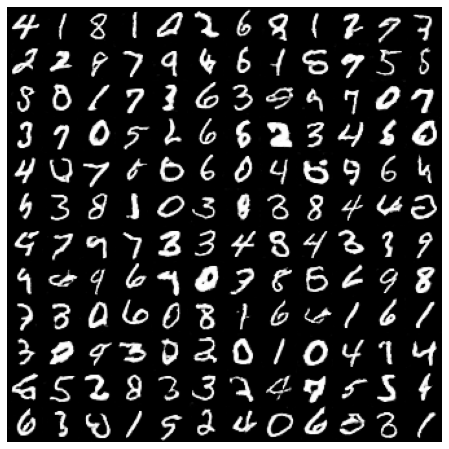

Epoch 14
[14][8400][0/600] Loss_D: 0.7288 Loss_G: 1.6922 D(x): 0.5595 D(G(z)): 0.0549
[14][8500][100/600] Loss_D: 0.6695 Loss_G: 1.5814 D(x): 0.5906 D(G(z)): 0.0589
[14][8600][200/600] Loss_D: 0.6697 Loss_G: 0.9192 D(x): 0.6989 D(G(z)): 0.2073
[14][8700][300/600] Loss_D: 0.5584 Loss_G: 1.2033 D(x): 0.7098 D(G(z)): 0.1501
[14][8800][400/600] Loss_D: 0.5038 Loss_G: 2.3709 D(x): 0.8295 D(G(z)): 0.2379
[14][8900][500/600] Loss_D: 0.8394 Loss_G: 2.8289 D(x): 0.8796 D(G(z)): 0.4220


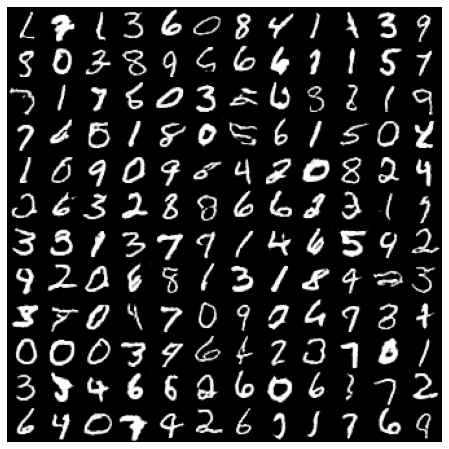

Epoch 15
[15][9000][0/600] Loss_D: 0.7182 Loss_G: 4.0638 D(x): 0.8160 D(G(z)): 0.3250
[15][9100][100/600] Loss_D: 0.3211 Loss_G: 2.0277 D(x): 0.9020 D(G(z)): 0.1749
[15][9200][200/600] Loss_D: 0.5025 Loss_G: 2.3622 D(x): 0.9068 D(G(z)): 0.2933
[15][9300][300/600] Loss_D: 0.6694 Loss_G: 0.9659 D(x): 0.6289 D(G(z)): 0.1192
[15][9400][400/600] Loss_D: 0.5833 Loss_G: 2.3294 D(x): 0.8902 D(G(z)): 0.3239
[15][9500][500/600] Loss_D: 0.9464 Loss_G: 0.9466 D(x): 0.4974 D(G(z)): 0.0978


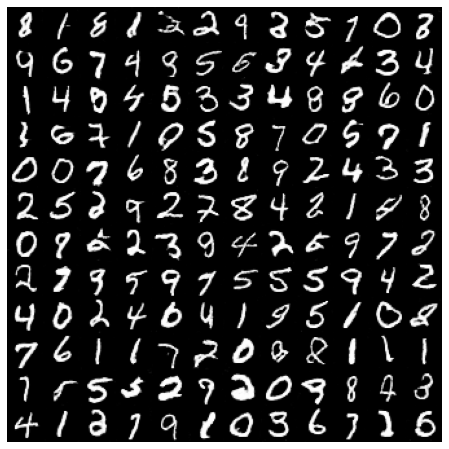

Epoch 16
[16][9600][0/600] Loss_D: 0.4752 Loss_G: 2.0255 D(x): 0.7889 D(G(z)): 0.1670
[16][9700][100/600] Loss_D: 0.5727 Loss_G: 1.1775 D(x): 0.6747 D(G(z)): 0.0958
[16][9800][200/600] Loss_D: 0.5753 Loss_G: 1.8918 D(x): 0.7356 D(G(z)): 0.1839
[16][9900][300/600] Loss_D: 0.5208 Loss_G: 2.3358 D(x): 0.8370 D(G(z)): 0.2435
[16][10000][400/600] Loss_D: 0.8034 Loss_G: 1.4219 D(x): 0.5576 D(G(z)): 0.0885
[16][10100][500/600] Loss_D: 0.6191 Loss_G: 1.1310 D(x): 0.6743 D(G(z)): 0.1575


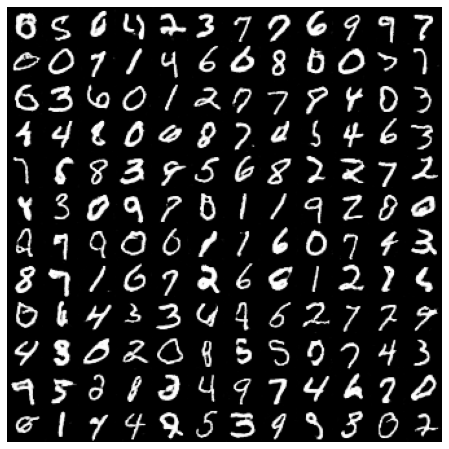

Epoch 17
[17][10200][0/600] Loss_D: 0.4301 Loss_G: 1.8537 D(x): 0.8579 D(G(z)): 0.2115
[17][10300][100/600] Loss_D: 0.4868 Loss_G: 2.5870 D(x): 0.7537 D(G(z)): 0.1401
[17][10400][200/600] Loss_D: 0.7765 Loss_G: 2.4233 D(x): 0.7271 D(G(z)): 0.2960
[17][10500][300/600] Loss_D: 0.6003 Loss_G: 2.3246 D(x): 0.8262 D(G(z)): 0.2824
[17][10600][400/600] Loss_D: 0.4554 Loss_G: 2.0642 D(x): 0.8473 D(G(z)): 0.2164
[17][10700][500/600] Loss_D: 0.8613 Loss_G: 3.4230 D(x): 0.8724 D(G(z)): 0.4526


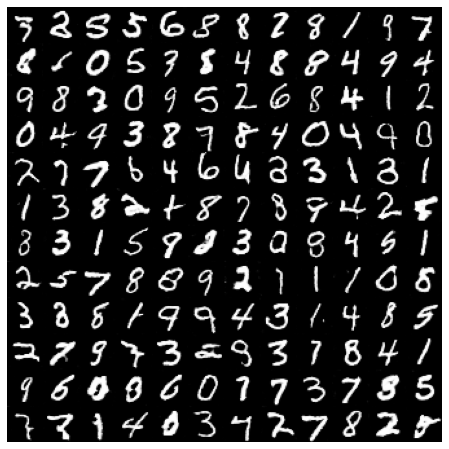

Epoch 18
[18][10800][0/600] Loss_D: 0.7110 Loss_G: 3.1108 D(x): 0.8767 D(G(z)): 0.3709
[18][10900][100/600] Loss_D: 0.6983 Loss_G: 3.1720 D(x): 0.9273 D(G(z)): 0.4005
[18][11000][200/600] Loss_D: 0.5763 Loss_G: 1.5516 D(x): 0.7559 D(G(z)): 0.1864
[18][11100][300/600] Loss_D: 0.9041 Loss_G: 3.1618 D(x): 0.9526 D(G(z)): 0.5163
[18][11200][400/600] Loss_D: 0.4538 Loss_G: 2.7126 D(x): 0.8505 D(G(z)): 0.2171
[18][11300][500/600] Loss_D: 0.7986 Loss_G: 1.0517 D(x): 0.5498 D(G(z)): 0.0698


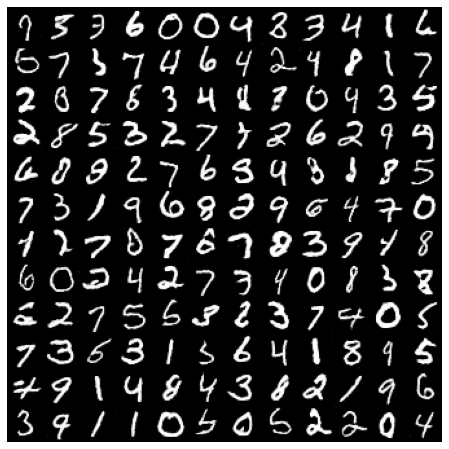

Epoch 19
[19][11400][0/600] Loss_D: 0.5200 Loss_G: 2.8349 D(x): 0.8704 D(G(z)): 0.2767
[19][11500][100/600] Loss_D: 0.3856 Loss_G: 1.7353 D(x): 0.8657 D(G(z)): 0.1862
[19][11600][200/600] Loss_D: 0.7355 Loss_G: 3.0330 D(x): 0.8391 D(G(z)): 0.3697
[19][11700][300/600] Loss_D: 1.0292 Loss_G: 1.5241 D(x): 0.4771 D(G(z)): 0.0829
[19][11800][400/600] Loss_D: 0.4792 Loss_G: 1.8280 D(x): 0.7803 D(G(z)): 0.1653
[19][11900][500/600] Loss_D: 0.7503 Loss_G: 2.1893 D(x): 0.5861 D(G(z)): 0.1145


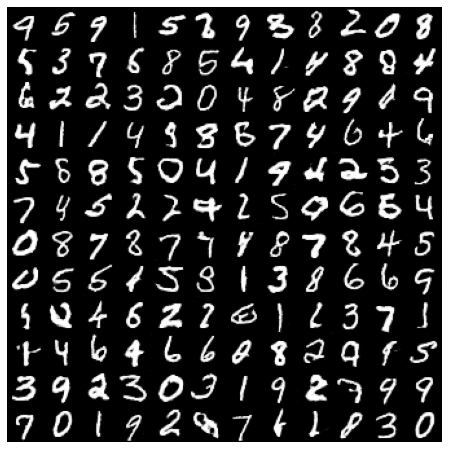

In [22]:
if not skip_training:
    # YOUR CODE HERE
    n_epochs = 20
    iters = 0
    n_critic = 50
    train_D_loss, train_G_loss = [], []
    optim_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    cumul_score = []

    for e in range(n_epochs):
        print(f"Epoch {e}")
        for i, batch in enumerate(data_loader):
            real_images, _ = map(lambda x: x.to(device), batch)
            # plt.imshow(real_images[0,0].cpu())
            # plt.show()
            bs = real_images.size(0)

            # Sample noise from a standard normal distribution.
            z = torch.randn(bs, nz, 1, 1, device=device)
            # Create fake images
            fake_images = netG(z)#.detach()

            ##################################################
            # 1st ) Update the discriminator : maximize log(D(x)) + log(1 - D(G(z)))
            ##################################################
            # if i % n_critic == 0:
            optim_D.zero_grad()

            # Compute the Discriminator loss
            d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_images, fake_images)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()  # backpropagate through D
            train_D_loss.append(d_loss.item())

            optim_D.step()
            

            ##################################################
            # 2nd ) Update the generator : maximize log(D(G(z)))
            ##################################################
            optim_G.zero_grad()
            
            # Sample noise from a standard normal distribution.
            z = torch.randn(bs, nz, 1, 1, device=device)
            # Create fake images
            fake_images = netG(z)#.detach()

            g_loss = generator_loss(netD, fake_images)
            g_loss.backward()  # backpropagate through G
            train_G_loss.append(g_loss.item())
            
            optim_G.step()

            if i % 100 == 0:
                print('[%d][%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
                % (e, iters, i, len(data_loader),
                    d_loss.item(), g_loss.item(), D_real, D_fake))
                
                # with torch.no_grad():
                #     # Plot generated images
                #     z = torch.randn(144, nz, 1, 1, device=device)
                #     samples = netG(z)
                #     plt.imshow(samples[0,0].cpu())
                #     plt.show()

            iters += 1

        with torch.no_grad():
            # Plot generated images
            z = torch.randn(144, nz, 1, 1, device=device)
            samples = netG(z)
            tools.plot_generated_samples(samples)
            
            # Compute score
            z = torch.randn(1000, nz, 1, 1, device=device)
            samples = netG(z)
            samples = (samples + 1) / 2  # Re-normalize to [0, 1]
            score = scorer(samples)
            cumul_score.append(score)

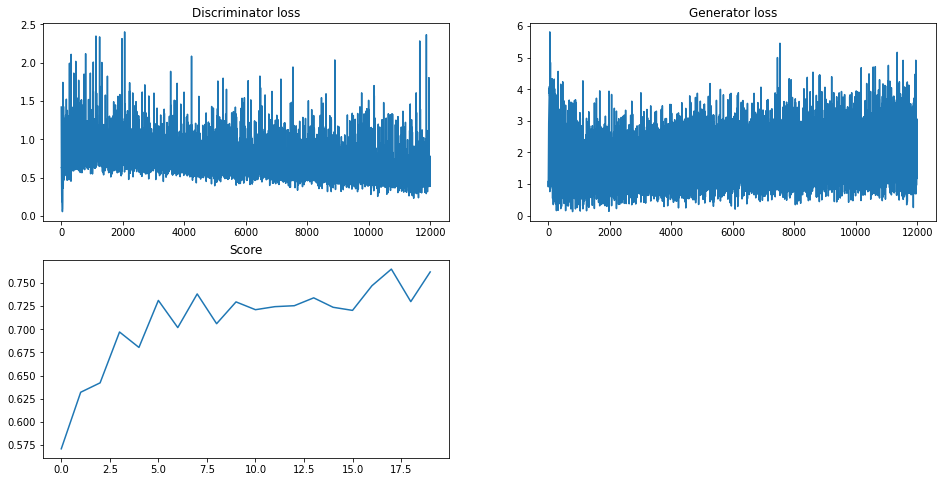

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
ax1.plot(train_D_loss, label='Discriminator')
ax1.set_title("Discriminator loss")
ax2.plot(train_G_loss, label='Generator')
ax2.set_title("Generator loss")
ax3.plot(cumul_score, label='Score')
ax3.set_title("Score")
ax4.remove()
# plt.legend()

In [24]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(netG, '11_dcgan_g.pth')
    tools.save_model(netD, '11_dcgan_d.pth')
else:
    nz = 10
    netG = Generator(nz=nz, ngf=64, nc=1)
    netD = Discriminator(nc=1, ndf=64)

    tools.load_model(netG, '11_dcgan_g.pth', device)
    tools.load_model(netD, '11_dcgan_d.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 11_dcgan_g.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 11_dcgan_d.pth.


In [25]:
# Evaluate generated samples
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = (netG(z) + 1) / 2
    score = scorer(samples)

print(f'The trained DCGAN achieves a score of {score:.5f}')
assert score >= 0.7, "Poor GAN score! Check your architecture and training."
print('Success')

The trained DCGAN achieves a score of 0.75384
Success
